# Pre-requisites

In [1]:
!pip install datasets --quiet
!pip install presidio-analyzer --quiet
!pip install presidio_anonymizer --quiet
!pip install presidio-anonymizer --quiet
!spacy download en_core_web_sm --quiet
!pip install transformers --quiet
!python -m spacy download en_core_web_lg --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [2]:
from datasets import load_dataset #Dataset, IterableDataset
import pprint
import json
import spacy
from google.colab import drive
drive.mount('/content/drive')
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from spacy import displacy
from tqdm import tqdm
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine, RecognizerResult
from datasets import load_dataset, load_from_disk, Dataset
from presidio_analyzer.nlp_engine import NlpEngineProvider
from presidio_analyzer import AnalyzerEngine, RecognizerRegistry
from presidio_analyzer.nlp_engine import NlpEngineProvider
from presidio_analyzer.nlp_engine import NerModelConfiguration, SpacyNlpEngine
from presidio_analyzer.nlp_engine import TransformersNlpEngine
from presidio_analyzer import (
    RecognizerResult,
    EntityRecognizer,
    AnalysisExplanation,
)
from typing import Optional, List
try:
    from transformers import (
        AutoTokenizer,
        AutoModelForTokenClassification,
        pipeline,
        TokenClassificationPipeline,
    )

except ImportError:
    logger.error("transformers is not installed")
from presidio_analyzer import AnalyzerEngine, RecognizerRegistry
from presidio_analyzer.nlp_engine import NlpEngineProvider
import spacy
import logging
logger = logging.getLogger("presidio-analyzer")
import torch
from presidio_analyzer.nlp_engine import NlpArtifacts
from presidio_anonymizer import DeanonymizeEngine
from presidio_anonymizer.entities import OperatorResult, OperatorConfig
import transformers
from huggingface_hub import snapshot_download
from transformers import AutoTokenizer, AutoModelForTokenClassification


Mounted at /content/drive


# Helper Functions & Globals

In [3]:
STANFORD_COFIGURATION = {
    "DEFAULT_MODEL_PATH": "StanfordAIMI/stanford-deidentifier-base",
    "PRESIDIO_SUPPORTED_ENTITIES": [
        "LOCATION",
        "PERSON",
        "ORGANIZATION",
        "AGE",
        "PHONE_NUMBER",
        "EMAIL",
        "DATE_TIME",
        "DEVICE",
        "ZIP",
        "PROFESSION",
        "USERNAME",
        "ID"

    ],
    "LABELS_TO_IGNORE": ["O"],
    "DEFAULT_EXPLANATION": "Identified as {} by the StanfordAIMI/stanford-deidentifier-base NER model",
    "SUB_WORD_AGGREGATION": "simple",
    "DATASET_TO_PRESIDIO_MAPPING": {
        "DATE": "DATE_TIME",
        "DOCTOR": "PERSON",
        "PATIENT": "PERSON",
        "HOSPITAL": "LOCATION",
        "MEDICALRECORD": "ID",
        "IDNUM": "ID",
        "ORGANIZATION": "ORGANIZATION",
        "ZIP": "ZIP",
        "PHONE": "PHONE_NUMBER",
        "USERNAME": "USERNAME",
        "STREET": "LOCATION",
        "PROFESSION": "PROFESSION",
        "COUNTRY": "LOCATION",
        "LOCATION-OTHER": "LOCATION",
        "FAX": "PHONE_NUMBER",
        "EMAIL": "EMAIL",
        "STATE": "LOCATION",
        "DEVICE": "DEVICE",
        "ORG": "ORGANIZATION",
        "AGE": "AGE",
    },
    "MODEL_TO_PRESIDIO_MAPPING": {
        "PER": "PERSON",
        "PERSON": "PERSON",
        "LOC": "LOCATION",
        "ORG": "ORGANIZATION",
        "AGE": "AGE",
        "PATIENT": "PERSON",
        "HCW": "PERSON",
        "HOSPITAL": "LOCATION",
        "PATORG": "ORGANIZATION",
        "DATE": "DATE_TIME",
        "PHONE": "PHONE_NUMBER",
        "VENDOR": "ORGANIZATION",
    },
    "CHUNK_OVERLAP_SIZE": 40,
    "CHUNK_SIZE": 600,
    "ID_SCORE_MULTIPLIER": 0.4,
    "ID_ENTITY_NAME": "ID"
}


BERT_DEID_CONFIGURATION = {
    "PRESIDIO_SUPPORTED_ENTITIES": [
        "LOCATION",
        "PERSON",
        "ORGANIZATION",
        "AGE",
        "PHONE_NUMBER",
        "EMAIL",
        "DATE_TIME",
        "ZIP",
        "PROFESSION",
        "USERNAME",
        "ID"
    ],
    "DEFAULT_MODEL_PATH": "obi/deid_roberta_i2b2",
    "LABELS_TO_IGNORE": ["O"],
    "DEFAULT_EXPLANATION": "Identified as {} by the obi/deid_roberta_i2b2 NER model",
    "SUB_WORD_AGGREGATION": "simple",
    "DATASET_TO_PRESIDIO_MAPPING": {
        "DATE": "DATE_TIME",
        "DOCTOR": "PERSON",
        "PATIENT": "PERSON",
        "HOSPITAL": "ORGANIZATION",
        "MEDICALRECORD": "O",
        "IDNUM": "O",
        "ORGANIZATION": "ORGANIZATION",
        "ZIP": "O",
        "PHONE": "PHONE_NUMBER",
        "USERNAME": "",
        "STREET": "LOCATION",
        "PROFESSION": "PROFESSION",
        "COUNTRY": "LOCATION",
        "LOCATION-OTHER": "LOCATION",
        "FAX": "PHONE_NUMBER",
        "EMAIL": "EMAIL",
        "STATE": "LOCATION",
        "DEVICE": "O",
        "ORG": "ORGANIZATION",
        "AGE": "AGE",
    },
    "MODEL_TO_PRESIDIO_MAPPING": {
        "PER": "PERSON",
        "LOC": "LOCATION",
        "ORG": "ORGANIZATION",
        "AGE": "AGE",
        "ID": "ID",
        "EMAIL": "EMAIL",
        "PATIENT": "PERSON",
        "STAFF": "PERSON",
        "HOSP": "ORGANIZATION",
        "PATORG": "ORGANIZATION",
        "DATE": "DATE_TIME",
        "PHONE": "PHONE_NUMBER",
    },
    "CHUNK_OVERLAP_SIZE": 40,
    "CHUNK_SIZE": 600,
    "ID_SCORE_MULTIPLIER": 0.4,
    "ID_ENTITY_NAME": "ID"
}
# label_list = ['O', 'B-NO_MASK', 'I-NO_MASK', 'B-DIRECT', 'I-DIRECT', 'B-QUASI', 'I-QUASI']
LONGFORMER_DEID_CONFIGURATION = {
    "PRESIDIO_SUPPORTED_ENTITIES": [
        "LOCATION",
        "PERSON",
        "ORGANIZATION",
        "AGE",
        "PHONE_NUMBER",
        "EMAIL",
        "DATE_TIME",
        "ZIP",
        "PROFESSION",
        "USERNAME",
        "ID"
    ],
    "DEFAULT_MODEL_PATH": "djliang/longformer_mask",
    "LABELS_TO_IGNORE": ["O"],
    "DEFAULT_EXPLANATION": "Identified as {} by the djliang/longformer_mask NER model",
    "SUB_WORD_AGGREGATION": "simple",
    "DATASET_TO_PRESIDIO_MAPPING": {
        "DATE": "DATE_TIME",
        "DOCTOR": "PERSON",
        "PATIENT": "PERSON",
        "HOSPITAL": "ORGANIZATION",
        "MEDICALRECORD": "O",
        "IDNUM": "O",
        "ORGANIZATION": "ORGANIZATION",
        "ZIP": "O",
        "PHONE": "PHONE_NUMBER",
        "USERNAME": "",
        "STREET": "LOCATION",
        "PROFESSION": "PROFESSION",
        "COUNTRY": "LOCATION",
        "LOCATION-OTHER": "LOCATION",
        "FAX": "PHONE_NUMBER",
        "EMAIL": "EMAIL",
        "STATE": "LOCATION",
        "DEVICE": "O",
        "ORG": "ORGANIZATION",
        "AGE": "AGE",
    },
    "MODEL_TO_PRESIDIO_MAPPING": {
        "PER": "PERSON",
        "LOC": "LOCATION",
        "ORG": "ORGANIZATION",
        "AGE": "AGE",
        "ID": "ID",
        "EMAIL": "EMAIL",
        "PATIENT": "PERSON",
        "STAFF": "PERSON",
        "HOSP": "ORGANIZATION",
        "PATORG": "ORGANIZATION",
        "DATE": "DATE_TIME",
        "PHONE": "PHONE_NUMBER",
        "LABEL_3": "PERSON",
        "LABEL_4": "PERSON",
        "LABEL_5": "PERSON",
        "LABEL_6": "PERSON",
    },
    "CHUNK_OVERLAP_SIZE": 40,
    "CHUNK_SIZE": 1000,
    "ID_SCORE_MULTIPLIER": 0.4,
    "ID_ENTITY_NAME": "ID"
}

In [4]:
class TransformersRecognizer(EntityRecognizer):
    """
    Wrapper for a transformers model, if needed to be used within Presidio Analyzer.
    The class loads models hosted on HuggingFace - https://huggingface.co/
    and loads the model and tokenizer into a TokenClassification pipeline.
    Samples are split into short text chunks, ideally shorter than max_length input_ids of the individual model,
    to avoid truncation by the Tokenizer and loss of information

    A configuration object should be maintained for each dataset-model combination and translate
    entities names into a standardized view. A sample of a configuration file is attached in
    the example.
    :param supported_entities: List of entities to run inference on
    :type supported_entities: Optional[List[str]]
    :param pipeline: Instance of a TokenClassificationPipeline including a Tokenizer and a Model, defaults to None
    :type pipeline: Optional[TokenClassificationPipeline], optional
    :param model_path: string referencing a HuggingFace uploaded model to be used for Inference, defaults to None
    :type model_path: Optional[str], optional

    :example
    >from presidio_analyzer import AnalyzerEngine, RecognizerRegistry
    >model_path = "obi/deid_roberta_i2b2"
    >transformers_recognizer = TransformersRecognizer(model_path=model_path,
    >supported_entities = model_configuration.get("PRESIDIO_SUPPORTED_ENTITIES"))
    >transformers_recognizer.load_transformer(**model_configuration)
    >registry = RecognizerRegistry()
    >registry.add_recognizer(transformers_recognizer)
    >analyzer = AnalyzerEngine(registry=registry)
    >sample = "My name is Christopher and I live in Irbid."
    >results = analyzer.analyze(sample, language="en",return_decision_process=True)

    >for result in results:
    >    print(result,'----', sample[result.start:result.end])
    """

    def load(self) -> None:
        pass

    def __init__(
        self,
        model_path: Optional[str] = None,
        pipeline: Optional[TokenClassificationPipeline] = None,
        supported_entities: Optional[List[str]] = None,
    ):
        if not supported_entities:
            supported_entities = BERT_DEID_CONFIGURATION[
                "PRESIDIO_SUPPORTED_ENTITIES"
            ]
        super().__init__(
            supported_entities=supported_entities,
            name=f"Transformers model {model_path}",
        )

        self.model_path = model_path
        self.pipeline = pipeline
        self.is_loaded = False

        self.aggregation_mechanism = None
        self.ignore_labels = None
        self.model_to_presidio_mapping = None
        self.entity_mapping = None
        self.default_explanation = None
        self.text_overlap_length = None
        self.chunk_length = None
        self.id_entity_name = None
        self.id_score_reduction = None

    def load_transformer(self, **kwargs) -> None:
        """Load external configuration parameters and set default values.

        :param kwargs: define default values for class attributes and modify pipeline behavior
        **DATASET_TO_PRESIDIO_MAPPING (dict) - defines mapping entity strings from dataset format to Presidio format
        **MODEL_TO_PRESIDIO_MAPPING (dict) -  defines mapping entity strings from chosen model format to Presidio format
        **SUB_WORD_AGGREGATION(str) - define how to aggregate sub-word tokens into full words and spans as defined
        in HuggingFace https://huggingface.co/transformers/v4.8.0/main_classes/pipelines.html#transformers.TokenClassificationPipeline # noqa
        **CHUNK_OVERLAP_SIZE (int) - number of overlapping characters in each text chunk
        when splitting a single text into multiple inferences
        **CHUNK_SIZE (int) - number of characters in each chunk of text
        **LABELS_TO_IGNORE (List(str)) - List of entities to skip evaluation. Defaults to ["O"]
        **DEFAULT_EXPLANATION (str) - string format to use for prediction explanations
        **ID_ENTITY_NAME (str) - name of the ID entity
        **ID_SCORE_REDUCTION (float) - score multiplier for ID entities
        """

        self.entity_mapping = kwargs.get("DATASET_TO_PRESIDIO_MAPPING", {})
        self.model_to_presidio_mapping = kwargs.get("MODEL_TO_PRESIDIO_MAPPING", {})
        self.ignore_labels = kwargs.get("LABELS_TO_IGNORE", ["O"])
        self.aggregation_mechanism = kwargs.get("SUB_WORD_AGGREGATION", "simple")
        self.default_explanation = kwargs.get("DEFAULT_EXPLANATION", None)
        self.text_overlap_length = kwargs.get("CHUNK_OVERLAP_SIZE", 40)
        self.chunk_length = kwargs.get("CHUNK_SIZE", 600)
        self.id_entity_name = kwargs.get("ID_ENTITY_NAME", "ID")
        self.id_score_reduction = kwargs.get("ID_SCORE_REDUCTION", 0.5)

        if not self.pipeline:
            if not self.model_path:
                self.model_path = "obi/deid_roberta_i2b2"
                logger.warning(
                    f"Both 'model' and 'model_path' arguments are None. Using default model_path={self.model_path}"
                )

        self._load_pipeline()

    def _load_pipeline(self) -> None:
        """Initialize NER transformers pipeline using the model_path provided"""

        logging.debug(f"Initializing NER pipeline using {self.model_path} path")
        device = 0 if torch.cuda.is_available() else -1
        self.pipeline = pipeline(
            "ner",
            model=AutoModelForTokenClassification.from_pretrained(self.model_path),
            tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096', add_prefix_space=True, max_length='longest'),

            #use lf tokenizer, not custom model
            #tokenizer=AutoTokenizer.from_pretrained(self.model_path),

            # Will attempt to group sub-entities to word level
            aggregation_strategy=self.aggregation_mechanism,
            device=device,
            framework="pt",
            ignore_labels=self.ignore_labels,
        )

        self.is_loaded = True

    def get_supported_entities(self) -> List[str]:
        """
        Return supported entities by this model.
        :return: List of the supported entities.
        """
        return self.supported_entities

    # Class to use transformers with Presidio as an external recognizer.
    def analyze(
        self, text: str, entities: List[str], nlp_artifacts: NlpArtifacts = None
    ) -> List[RecognizerResult]:
        """
        Analyze text using transformers model to produce NER tagging.
        :param text : The text for analysis.
        :param entities: The list of entities this recognizer is able to detect
        :param nlp_artifacts: Not used by this recognizer.
        :return: The list of Presidio RecognizerResult constructed from the recognized
            transformers detections.
        """

        results = list()
        # Run transformer model on the provided text
        ner_results = self._get_ner_results_for_text(text)

        for res in ner_results:
            res["entity_group"] = self.__check_label_transformer(res["entity_group"])
            if not res["entity_group"] or res["entity_group"] not in entities:
                continue

            if res["entity_group"] == self.id_entity_name:
                print(f"ID entity found, multiplying score by {self.id_score_reduction}")
                res["score"] = res["score"] * self.id_score_reduction

            textual_explanation = self.default_explanation.format(res["entity_group"])
            explanation = self.build_transformers_explanation(
                float(round(res["score"], 2)), textual_explanation, res["word"]
            )
            transformers_result = self._convert_to_recognizer_result(res, explanation)

            results.append(transformers_result)

        return results

    @staticmethod
    def split_text_to_word_chunks(
        input_length: int, chunk_length: int, overlap_length: int
    ) -> List[List]:
        """The function calculates chunks of text with size chunk_length. Each chunk has overlap_length number of
        words to create context and continuity for the model

        :param input_length: Length of input_ids for a given text
        :type input_length: int
        :param chunk_length: Length of each chunk of input_ids.
        Should match the max input length of the transformer model
        :type chunk_length: int
        :param overlap_length: Number of overlapping words in each chunk
        :type overlap_length: int
        :return: List of start and end positions for individual text chunks
        :rtype: List[List]
        """
        if input_length < chunk_length:
            return [[0, input_length]]
        if chunk_length <= overlap_length:
            logger.warning(
                "overlap_length should be shorter than chunk_length, setting overlap_length to by half of chunk_length"
            )
            overlap_length = chunk_length // 2
        return [
            [i, min([i + chunk_length, input_length])]
            for i in range(
                0, input_length - overlap_length, chunk_length - overlap_length
            )
        ]

    def _get_ner_results_for_text(self, text: str) -> List[dict]:
        """The function runs model inference on the provided text.
        The text is split into chunks with n overlapping characters.
        The results are then aggregated and duplications are removed.

        :param text: The text to run inference on
        :type text: str
        :return: List of entity predictions on the word level
        :rtype: List[dict]
        """
        model_max_length = self.pipeline.tokenizer.model_max_length
        # calculate inputs based on the text
        text_length = len(text)
        # split text into chunks
        if text_length <= model_max_length:
            predictions = self.pipeline(text)
        else:
            logger.info(
                f"splitting the text into chunks, length {text_length} > {model_max_length}"
            )
            predictions = list()
            chunk_indexes = TransformersRecognizer.split_text_to_word_chunks(
                text_length, self.chunk_length, self.text_overlap_length
                )

            # iterate over text chunks and run inference
            for chunk_start, chunk_end in chunk_indexes:
                chunk_text = text[chunk_start:chunk_end]
                chunk_preds = self.pipeline(chunk_text)

                # align indexes to match the original text - add to each position the value of chunk_start
                aligned_predictions = list()
                for prediction in chunk_preds:
                    prediction_tmp = copy.deepcopy(prediction)
                    prediction_tmp["start"] += chunk_start
                    prediction_tmp["end"] += chunk_start
                    aligned_predictions.append(prediction_tmp)

                predictions.extend(aligned_predictions)

        # remove duplicates
        predictions = [dict(t) for t in {tuple(d.items()) for d in predictions}]
        return predictions

    @staticmethod
    def _convert_to_recognizer_result(
        prediction_result: dict, explanation: AnalysisExplanation
    ) -> RecognizerResult:
        """The method parses NER model predictions into a RecognizerResult format to enable down the stream analysis

        :param prediction_result: A single example of entity prediction
        :type prediction_result: dict
        :param explanation: Textual representation of model prediction
        :type explanation: str
        :return: An instance of RecognizerResult which is used to model evaluation calculations
        :rtype: RecognizerResult
        """

        transformers_results = RecognizerResult(
            entity_type=prediction_result["entity_group"],
            start=prediction_result["start"],
            end=prediction_result["end"],
            score=float(round(prediction_result["score"], 2)),
            analysis_explanation=explanation,
        )

        return transformers_results

    def build_transformers_explanation(
        self,
        original_score: float,
        explanation: str,
        pattern: str,
    ) -> AnalysisExplanation:
        """
        Create explanation for why this result was detected.
        :param original_score: Score given by this recognizer
        :param explanation: Explanation string
        :param pattern: Regex pattern used
        :return Structured explanation and scores of a NER model prediction
        :rtype: AnalysisExplanation
        """
        explanation = AnalysisExplanation(
            recognizer=self.__class__.__name__,
            original_score=float(original_score),
            textual_explanation=explanation,
            pattern=pattern,
        )
        return explanation

    def __check_label_transformer(self, label: str) -> Optional[str]:
        """The function validates the predicted label is identified by Presidio
        and maps the string into a Presidio representation
        :param label: Predicted label by the model
        :return: Returns the adjusted entity name
        """

        # convert model label to presidio label
        entity = self.model_to_presidio_mapping.get(label, None)

        if entity in self.ignore_labels:
            return None

        if entity is None:
            logger.warning(f"Found unrecognized label {label}, returning entity as is")
            return label

        if entity not in self.supported_entities:
            logger.warning(f"Found entity {entity} which is not supported by Presidio")
            return entity
        return entity


In [5]:
# full, test dataset select data slicing of original json
# global variables
model_name = 'presidio-longformer_mask' # update to select the right path
task = 'mask'
size = 'full'
split = 'test'
# replace,redact, hash, mask
anonymization = 'redact'

In [6]:
path = '/content/drive/MyDrive/266 - Natural Language Processing/Final Project/'

# Analyzer

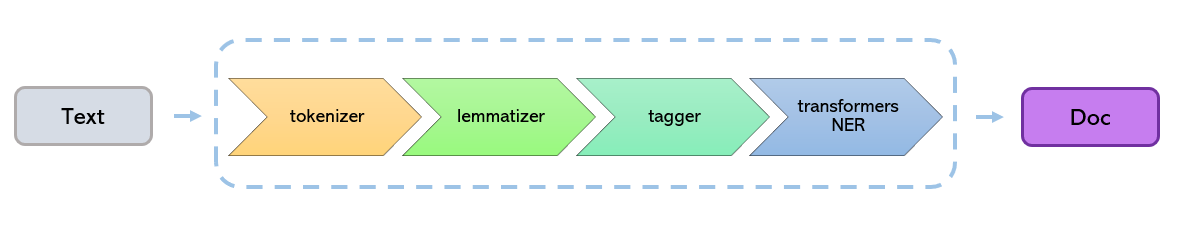

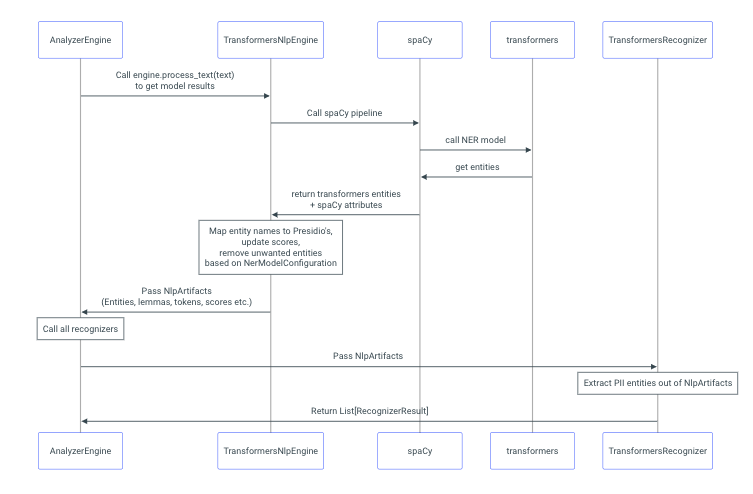

## deid_roberta_i2b2

In [7]:

# transformers_model = "obi/deid_roberta_i2b2" # e.g. "obi/deid_roberta_i2b2"

# snapshot_download(repo_id=transformers_model)

# # Instantiate to make sure it's downloaded during installation and not runtime
# AutoTokenizer.from_pretrained(transformers_model)
# AutoModelForTokenClassification.from_pretrained(transformers_model)

## Longformer

In [8]:
# import transformers
# from huggingface_hub import snapshot_download
# from transformers import AutoTokenizer, AutoModelForTokenClassification

# transformers_model = "djliang/longformer_mask" # e.g. "obi/deid_roberta_i2b2"

# snapshot_download(repo_id=transformers_model)

# # Instantiate to make sure it's downloaded during installation and not runtime
# transformers_model_tokenizer = "allenai/longformer-base-4096"  # e.g. "obi/deid_roberta_i2b2"

# AutoTokenizer.from_pretrained(transformers_model_tokenizer)
# AutoModelForTokenClassification.from_pretrained(transformers_model)

In [9]:
model_path = "djliang/longformer_mask"
supported_entities = LONGFORMER_DEID_CONFIGURATION.get(
    "PRESIDIO_SUPPORTED_ENTITIES")
transformers_recognizer = TransformersRecognizer(model_path=model_path,
                                                 supported_entities=supported_entities)

# This would download a large (~500Mb) model on the first run
transformers_recognizer.load_transformer(**LONGFORMER_DEID_CONFIGURATION)

# Add transformers model to the registry
registry = RecognizerRegistry()
registry.add_recognizer(transformers_recognizer)
registry.remove_recognizer("SpacyRecognizer")

# Use small spacy model, for faster inference.
if not spacy.util.is_package("en_core_web_sm"):
    spacy.cli.download("en_core_web_sm")

nlp_configuration = {
    "nlp_engine_name": "spacy",
    "models": [{"lang_code": "en", "model_name": "en_core_web_sm"}],
}

nlp_engine = NlpEngineProvider(nlp_configuration=nlp_configuration).create_engine()

analyzer = AnalyzerEngine(registry=registry, nlp_engine=nlp_engine)

sample = "My name is John and I live in NY. Additional sample text that might capture location like New York, Los Angeles or Miami. Names like John Doe and others should be recognized."
results = analyzer.analyze(sample, language="en",
                           return_decision_process=True,
                           )
print("Found the following entities:")
for result in results:
    print(result, '----', sample[result.start:result.end])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/592M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Input ids are automatically padded to be a multiple of `config.attention_window`: 512


Found the following entities:
type: PERSON, start: 133, end: 137, score: 0.6800000071525574 ---- John
type: PERSON, start: 30, end: 32, score: 0.6299999952316284 ---- NY
type: PERSON, start: 138, end: 141, score: 0.6200000047683716 ---- Doe
type: PERSON, start: 90, end: 98, score: 0.5799999833106995 ---- New York
type: PERSON, start: 115, end: 120, score: 0.5799999833106995 ---- Miami
type: PERSON, start: 100, end: 111, score: 0.5199999809265137 ---- Los Angeles
type: PERSON, start: 11, end: 15, score: 0.5 ---- John


In [10]:
# general functions
def select_data(split, task, size):
    """
    Loads the appropriate dataset per folder structure here: https://drive.google.com/drive/folders/1C3h3rXdbr9nVAC3_G_I-72DfKNiDU_Pa
    Input:
        Split: ['train', 'val', 'test']
        Task: ['ner', 'mask', 'both']
        Size: ['testing', 'mini', 'full']
    Returns:
        Huggingface dataset
    """
    if split not in ['train', 'val', 'test']:
        raise ValueError("Split value must be in ['train', 'val', 'test']")
    if task not in ['ner', 'mask', 'both']:
        raise ValueError("Task value must be in ['ner', 'mask', 'both']")
    if size not in ['testing', 'mini', 'full']:
        raise ValueError("Size value must be in ['testing', 'mini', 'full']")

    path_label = {'both': 'longformer', 'ner': 'longformer_ner', 'mask': 'longformer_mask'}
    # path_label = {'both': 'longformer', 'ner': 'longformer_ner', 'mask': 'longformer_4096'}

    if size == 'testing':
        ds = load_from_disk(f'{path}/data/tab/{path_label[task]}/lf_{split}_testing')
    if size == 'mini':
        if split == 'train':
            ds = load_from_disk(f'{path}/data/tab/{path_label[task]}/lf_{split}_400')
        else:
            ds = load_from_disk(f'{path}/data/tab/{path_label[task]}/lf_{split}_50')
    if size == 'full':
        ds = load_from_disk(f'{path}/data/tab/{path_label[task]}/lf_{split}')

    return ds

In [11]:
ds = select_data(split, task, size)
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'ner_tags', 'mask_tags', 'text_spans', 'tokens', 'text', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 98
    })
})

ner_type = ['O', 'B-PERSON', 'I-PERSON', 'B-CODE', 'I-CODE', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG',
            'B-DEM', 'I-DEM', 'B-DATETIME', 'I-DATETIME', 'B-QUANTITY', 'I-QUANTITY', 'B-MISC', 'I-MISC']
masking_type = ['NO_MASK', 'DIRECT', 'QUASI']

# Sample Presidio Output

In [12]:


# # Set up the engine, loads the NLP module (spaCy model by default) and other PII recognizers
# analyzer = AnalyzerEngine()

# # Call analyzer to get results
# results = analyzer.analyze(text=ds['train'][0]['text'],
#                            #entities=["PHONE_NUMBER"],
#                            language='en')
# print(results)

In [13]:
#results

# Evaluation

Assuming that DIRECT or QUASI mask types are both masked per the publication

In [14]:
# def predict_mask_labels(dataset):
#     """
#     Uses Presidio's AnalyzerEngine to predict binary MASK labels for tokens in each text,
#     calculating end positions based on token start positions.
#     """
#     predictions = []
#     ground_truths = []

#     for example in tqdm(dataset):
#         text = example['text']
#         mask_tags = example['mask_tags']  # Ground truth mask tags (1 or 2 for MASK, 0 for NO MASK)

#         # Convert mask_tags to binary (1 for MASK, 0 for NO MASK)
#         binary_ground_truths = [1 if tag in [1, 2] else 0 for tag in mask_tags]

#         # Run Presidio's analyzer to detect PII entities in the text
#         results = analyzer.analyze(text=text, entities=[], language="en")

#         # Initialize all tokens as NO MASK (0), and set entities to MASK (1)
#         predicted_mask_tags = [0] * len(example['tokens'])
#         num_tokens = len(example['tokens'])

#         for result in results:
#             # Each result contains the start and end character indices of detected PII
#             entity_start = result.start
#             entity_end = result.end

#             # Loop through tokens and assign MASK based on entity spans
#             for i, token_start in enumerate(example['text_spans']):
#                 # Calculate end position of the token
#                 if i < num_tokens - 1:
#                     token_end = example['text_spans'][i + 1]
#                 else:
#                     token_end = len(text)  # Last token to end of text

#                 # Check if the token is within the entity span
#                 if token_start >= entity_start and token_start < entity_end:
#                     predicted_mask_tags[i] = 1  # Set as MASK

#         predictions.extend(predicted_mask_tags)
#         ground_truths.extend(binary_ground_truths)

#     return predictions, ground_truths

In [15]:
# # Run prediction and gather results
# predictions, ground_truths = predict_mask_labels(ds['train'])

# # Evaluate using classification report
# print(classification_report(ground_truths, predictions, target_names=["NO MASK", "MASK"]))

In [16]:
# # Generate the confusion matrix
# conf_matrix = confusion_matrix(ground_truths, predictions)

# # Plotting the heatmap
# plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["NO MASK", "MASK"], yticklabels=["NO MASK", "MASK"])
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Confusion Matrix Heatmap")
# plt.show

In [17]:
# len(predictions)

# Anonymizer

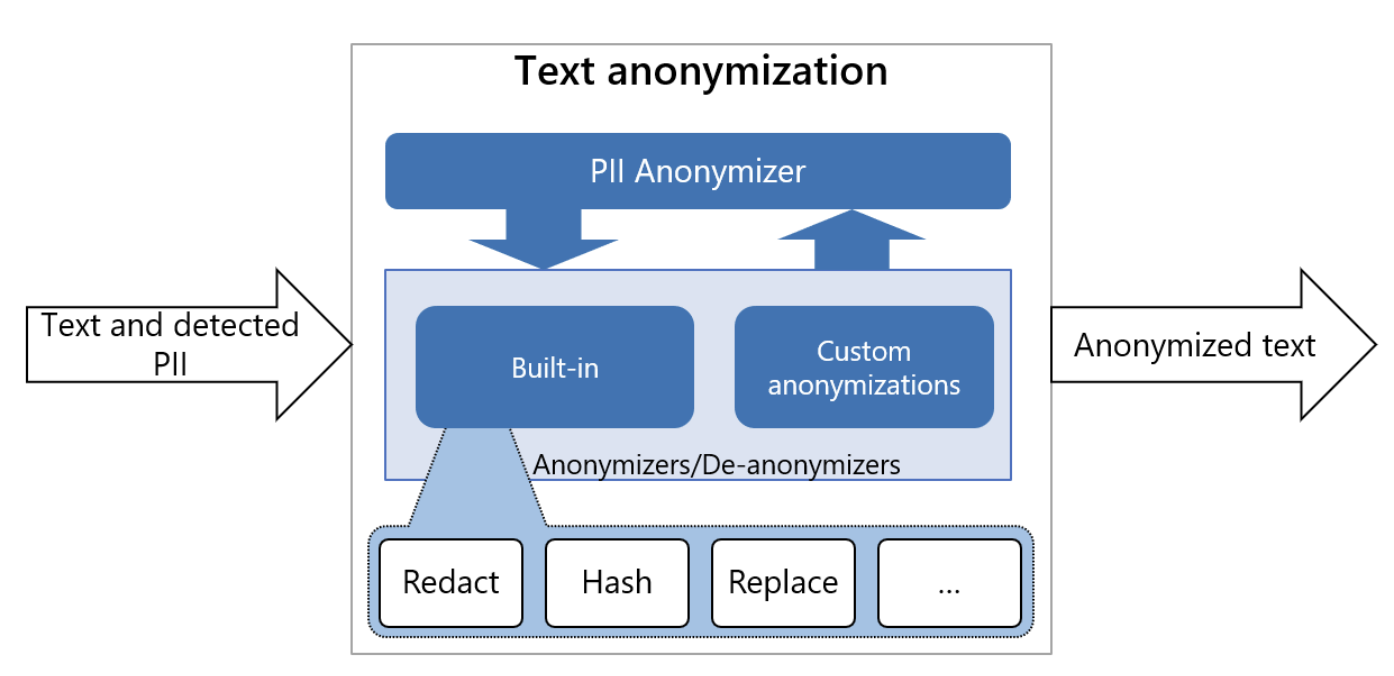

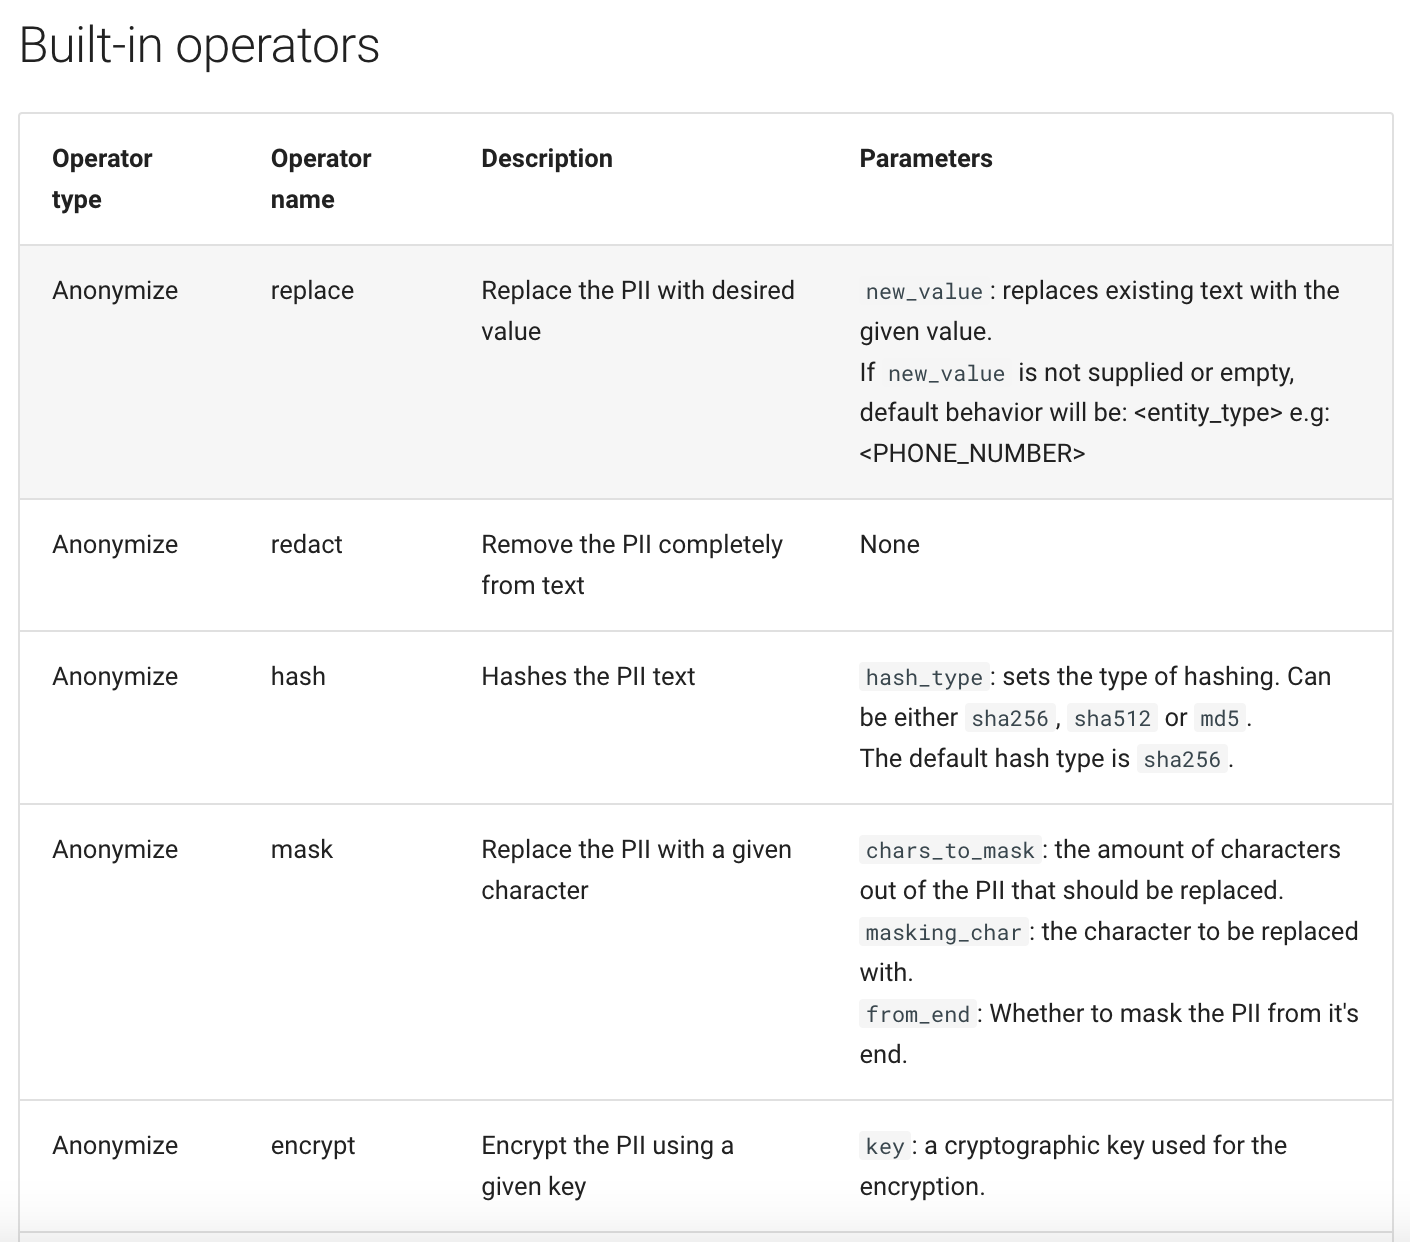

Replacement

In [18]:
# from presidio_anonymizer import AnonymizerEngine
# from presidio_anonymizer.entities import RecognizerResult, OperatorConfig

# # Initialize the engine:
# engine = AnonymizerEngine()

# # Invoke the anonymize function with the text,
# # analyzer results (potentially coming from presidio-analyzer) and
# # Operators to get the anonymization output:
# result = engine.anonymize(
#     text="My name is Bond, James Bond",
#     analyzer_results=[
#         RecognizerResult(entity_type="PERSON", start=11, end=15, score=0.8),
#         RecognizerResult(entity_type="PERSON", start=17, end=27, score=0.8),
#     ],
#     operators={"PERSON": OperatorConfig("replace", {"new_value": "[MASK]"})},
# )

# print(result)

Encryption

In [19]:
# from presidio_anonymizer import DeanonymizeEngine
# from presidio_anonymizer.entities import OperatorResult, OperatorConfig

# # Initialize the engine:
# engine = DeanonymizeEngine()

# # Invoke the deanonymize function with the text, anonymizer results and
# # Operators to define the deanonymization type.
# result = engine.deanonymize(
#     text="My name is S184CMt9Drj7QaKQ21JTrpYzghnboTF9pn/neN8JME0=",
#     entities=[
#         OperatorResult(start=11, end=55, entity_type="PERSON"),
#     ],
#     operators={"DEFAULT": OperatorConfig("decrypt", {"key": "WmZq4t7w!z%C&F)J"})},
# )

# print(result)

Use Anonymizer pipeline to produce new text

In [20]:

# # Initialize Presidio components
# analyzer = AnalyzerEngine()
anonymizer = AnonymizerEngine()

In [21]:
match anonymization:
    case "replace":
         operator_config = {
              "operators": {
                  "PERSON": OperatorConfig("replace", {"new_value": "[Mask]"}),
                  # Add more entity-specific configurations as needed
              }
          }
    case "redact":
         operator_config = {
              "operators": {
                  "PERSON": OperatorConfig("redact"),
                  # Add more entity-specific configurations as needed
              }
          }
    case "hash":
         operator_config = {
              "operators": {
                  "PERSON": OperatorConfig("hash", {"hash_type": "sha256"}),
                  # Add more entity-specific configurations as needed
              }
          }
    case "mask":
         operator_config = {
              "operators": {
                  "PHONE_NUMBER": OperatorConfig(
                      "mask",
                      {
                          "type": "mask",
                          "masking_char": "*",
                          "chars_to_mask": 50,
                          "from_end": True,
                      },
    ),
              }
          }
    case _:
         operator_config = {
              "operators": {
                  "PERSON": OperatorConfig("replace", {"new_value": "[Mask]"}),
                  # Add more entity-specific configurations as needed
              }
          }

In [22]:

# # Define custom operator configurations for specific entity types and a DEFAULT configuration

# # Define operator configurations for specific entity types
# operator_config = {
#     "operators": {
#         "PERSON": OperatorConfig("replace", {"new_value": "[Mask]"}),
#         "LOCATION": OperatorConfig("redact"),  # Example of redaction
#         # Add more entity-specific configurations as needed
#     }
# }

In [23]:
def anonymize_text_with_presidio(dataset, operator_config=None, chunk_size=None):
    """
    Anonymizes each text in the dataset using Presidio with specified operator configurations, with optional text chunking.

    Parameters:
    - dataset (list): A list of dictionaries, where each dictionary represents a text example with "id" and "text" keys.
    - operator_config (dict): A dictionary containing a single key "operators" which maps entity types
                              (e.g., "PERSON", "LOCATION") to their respective OperatorConfig instances.
                              Example: {"operators": {"PERSON": OperatorConfig("replace", {"new_value": "BIP"})}}
    - chunk_size (int, optional): The maximum size of each text chunk for processing. If None, the text is not chunked.

    Returns:
    - anonymized_texts (list): List of dictionaries containing "doc_id", "original_text", and "anonymized_text".
    - minimal_data (dict): Dictionary containing "doc_id" as keys and masked spans as values.
    """
    anonymized_texts = []  # List to store anonymized texts for each example
    operators = operator_config.get("operators", {})  # Get the operators from operator_config
    minimal_data = {}  # Dictionary to store minimal data with doc_id as keys

    for example in tqdm(dataset, desc="Anonymizing dataset"):
        text = example['text']
        doc_id = example["id"]

        # Initialize storage for anonymized chunks
        anonymized_chunks = []
        all_masked_spans = []
        offset = 0

        # Split text into chunks if chunk_size is specified
        if chunk_size:
            chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
        else:
            chunks = [text]  # No chunking if chunk_size is None

        for chunk in chunks:
            # Analyze the text for PII
            analysis_results = analyzer.analyze(
                text=chunk,
                language='en',
                return_decision_process=True,
            )

            # Configure anonymizers based on operator_config or fallback to default if provided
            anonymizer_configs = {
                result.entity_type: operators.get(result.entity_type, operator_config)
                for result in analysis_results
            }

            # Apply the anonymizer to the chunk with the configured settings
            anonymized_result = anonymizer.anonymize(
                text=chunk,
                analyzer_results=analysis_results,
                operators=anonymizer_configs
            )

            # Collect masked spans for the chunk and adjust based on the offset
            masked_spans = [
                (result.start + offset, result.end + offset)
                for result in analysis_results
            ]

            # Append results
            anonymized_chunks.append(anonymized_result.text)
            all_masked_spans.extend(masked_spans)
            offset += len(chunk)

        # Reconstruct the anonymized text
        anonymized_text = ''.join(anonymized_chunks)

        # Add the anonymized text to the results list
        anonymized_texts.append({
            "doc_id": doc_id,
            "original_text": text,
            "anonymized_text": anonymized_text,
        })

        # Store in minimal data dictionary with doc_id as key
        minimal_data[doc_id] = {
            "doc_id": doc_id,
            "masked_spans": all_masked_spans
        }

    return anonymized_texts, minimal_data

In [24]:
# def anonymize_text_with_presidio(dataset, operator_config=None):
#     """
#     Anonymizes each text in the dataset using Presidio with specified operator configurations.

#     Parameters:
#     - operator_config (dict): A dictionary containing a single key "operators" which maps entity types
#                               (e.g., "PERSON", "LOCATION") to their respective OperatorConfig instances.
#                               Example: {"operators": {"PERSON": OperatorConfig("replace", {"new_value": "BIP"})}}
#     """
#     anonymized_texts = []  # List to store anonymized texts for each example
#     operators = operator_config.get("operators", {})  # Get the operators from operator_config
#     minimal_data = {}      # Dictionary to store minimal data with doc_id as keys

#     # Default operator configuration to use if no specific config is found
#     #default_config = OperatorConfig("replace", {"new_value": "[MASK]"})

#     for example in tqdm(dataset, desc="Anonymizing dataset"):
#         text = example['text']
#         doc_id = example["id"]

#         # Analyze the text for PII
#         analysis_results = analyzer.analyze(text=text, language='en', return_decision_process=True,)

#         # Configure anonymizers based on operator_config or fallback to the DEFAULT if provided
#         anonymizer_configs = {
#             result.entity_type: operators.get(result.entity_type, operator_config)
#             for result in analysis_results
#         }

#         # Apply the anonymizer to the text with the configured settings
#         anonymized_result = anonymizer.anonymize(
#             text=text,
#             analyzer_results=analysis_results,
#             operators=anonymizer_configs
#         )

#         # Collect masked spans as [start, end] positions
#         masked_spans = [(result.start, result.end) for result in analysis_results]

#         # Add the anonymized text to the results list
#         anonymized_texts.append({
#             "doc_id": doc_id,
#             "original_text": text,
#             "anonymized_text": anonymized_result.text,
#         })

#         # Store in minimal data dictionary with doc_id as key
#         minimal_data[doc_id] = {
#             "doc_id": doc_id,
#             "masked_spans": masked_spans
#         }



#     return anonymized_texts, minimal_data

In [25]:
len(ds['train'][26]['text'])

28479

In [26]:
# # Analyze the text for PII
# analysis_results = analyzer.analyze(text=ds['train'][26]['text'], language='en', return_decision_process=True,)
# operators = operator_config.get("operators", {})  # Get the operators from operator_config
# # Configure anonymizers based on operator_config or fallback to the DEFAULT if provided
# anonymizer_configs = {
#     result.entity_type: operators.get(result.entity_type, operator_config)
#     for result in analysis_results
# }

# # Apply the anonymizer to the text with the configured settings
# anonymized_result = anonymizer.anonymize(
#     text=ds['train'][26]['text'],
#     analyzer_results=analysis_results,
#     operators=anonymizer_configs
#         )

In [27]:
# Anonymize texts using the operator_config only
anonymized_texts, anonymized_texts_minimal = anonymize_text_with_presidio(ds['train'], operator_config=operator_config, chunk_size = 10000)


Streaming output truncated to the last 5000 lines.
Anonymizing dataset: 100%|██████████| 98/98 [23:33<00:00, 14.42s/it]


In [28]:
anonymized_texts

[{'doc_id': '001-61807',
  'original_text': 'PROCEDURE\n\nThe case originated in an application (no. 36110/97) against the Republic of Turkey lodged with the European Commission of Human Rights (“the Commission”) under former Article 25 of the Convention for the Protection of Human Rights and Fundamental Freedoms (“the Convention”) by four Turkish nationals, Mr Galip Yalman, Mr Bahattin Sarısoy, Mr Osman Çağlayan and Mr Yusuf Çamca (“the applicants”), on 29 November 1996.\n\nThe applicants were represented by Mr S. Esmer, a lawyer practising in Ankara. The Turkish Government (“the Government”) did not designate an Agent for the purposes of the proceedings before the Convention institutions.\n\nThe applicants alleged that their case, which commenced in 1989 and terminated in 1996, was not heard within a reasonable time as required by the Convention.\n\nThe application was transmitted to the Court on 1 November 1998, when Protocol No. 11 to the Convention came into force (Article 5 § 2 o

In [29]:

# Save the output to a JSON file
with open(f'{path}data/tab/echr_{model_name}_{split}_{size}_{task}_{anonymization}_masked_spans_gold.json', "w") as output_file:
    json.dump(anonymized_texts, output_file, indent=4)

print("Presidio Anonymized texts saved as JSON file.")

# Save the output to a JSON file
with open(f'{path}data/tab/echr_{model_name}_{split}_{size}_{task}_{anonymization}_masked_spans.json', "w") as output_file:
    json.dump(anonymized_texts_minimal, output_file, indent=4)

print("Presidio Anonymized text spans saved as JSON file.")

Presidio Anonymized texts saved as JSON file.
Presidio Anonymized text spans saved as JSON file.
